In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
sns.set_style('whitegrid')

import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
#from torch.optim.lr_scheduler import StepLR

import time

In [2]:
# Parameters
params_dictionary = {
    'hidden size': 50,
    'hidden size 2': 10,
    'layers': 1,
    'learning rate': 0.001,
    'epochs': 500,
    'alpha' : 4
}

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
        
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

# Make the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce GTX 1070


In [4]:
# Upload the data frame into the notebook
data_frame = pd.read_csv('Data/data_random_system_independent_batches_32_100_100_unstable_2.csv')
kalman_results = pd.read_csv('Data/kalman_results_random_system_independent_batches_32_100_100_unstable_2.csv')

In [5]:
display(data_frame.head(5))

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20
0,-0.697455,-1.245930,-0.202538,-1.500699,2.656404,-0.939804,-0.043719,-1.971381,-1.549936,-0.988254,...,-0.197206,-0.057530,0.116169,0.064326,0.567743,0.664145,-0.184236,0.356302,-0.038459,-0.046502
1,-1.431445,-6.179983,-2.194823,-5.057230,9.299982,-3.348621,0.441717,-6.070506,-5.795829,-0.390525,...,-0.799254,-0.674372,0.257887,0.593830,2.336417,2.484704,-0.436298,0.896194,-0.359418,-0.008876
2,-6.648207,-27.271588,-14.078996,-24.911520,41.909946,-11.040103,4.176286,-26.738059,-27.317243,-2.817538,...,-2.792074,-4.707695,0.355372,3.065924,10.579507,11.950205,-1.744600,4.546978,-2.211173,0.563690
3,-26.648483,-129.771307,-91.908164,-123.744412,191.684295,-30.964361,27.648203,-121.499324,-134.458536,-15.127361,...,-10.246214,-30.400518,-2.048972,17.735535,49.769135,58.804624,-7.454173,22.242469,-13.313440,5.723387
4,-100.876870,-616.609978,-585.103763,-624.469076,872.511913,-24.560002,178.289069,-554.632175,-667.092798,-103.916966,...,-32.434727,-191.443187,-30.101263,104.930736,233.488510,293.413324,-35.238374,114.389785,-76.698969,40.801384


In [6]:
# Degrees of freedom
dof = 10

# Defining a batch size based on the data
seq_len = 100
batch_size = 32
num_batches = 100
num_seqs = int(data_frame.shape[0] / seq_len)
print(f'[DEBUG] number of sequences: {num_seqs}')

# Split the dataset into sequences
seq_data = np.array_split(data_frame,num_seqs,axis=0)
print(f'[DEBUG] data size: {len(seq_data)}')
kf_data = np.array_split(kalman_results,num_seqs,axis=0)
print(f'[DEBUG] Kalman data size: {len(kf_data)}')

# Randomly choose the validation sequences, and move them to the back of the dataset
num_val_seq = int(np.floor(num_seqs*0.2))
test_seq_ids = np.random.choice(num_seqs, num_val_seq, replace=False)

for i in range(num_val_seq):
    seq_data.append(seq_data.pop(test_seq_ids[i]))
    kf_data.append(kf_data.pop(test_seq_ids[i]))

# Combining all the sequences to form a single dataset
df = pd.DataFrame(np.concatenate(seq_data),columns=list(data_frame.columns))
kf = pd.DataFrame(np.concatenate(kf_data),columns=list(kalman_results.columns))

[DEBUG] number of sequences: 3200
[DEBUG] data size: 3200
[DEBUG] Kalman data size: 3200


In [7]:
# Get the size of the validation set
val_size = seq_len*num_val_seq

y = df.values.astype(float)
x_hat = kf.values.astype(float)

# Create train and test sets
train_set = y[:-val_size]
test_set = y[-val_size:]

kf_set = x_hat[-val_size:]

In [8]:
# Scaling the training and testing data 
#scaler1 = MinMaxScaler(feature_range=(-1, 1))
scaler1 = StandardScaler()
#scaler2 = MinMaxScaler(feature_range=(-1, 1))
scaler2 = StandardScaler()

# Fitting a scaler for states and inputs seperately
train_norm_inputs = scaler1.fit_transform(train_set[:,:dof].reshape(-1,dof))
train_norm_states = scaler2.fit_transform(train_set[:,dof:].reshape(-1,2*dof))

train_norm = np.hstack((train_norm_inputs, train_norm_states))

test_norm_inputs = scaler1.transform(test_set[:,:dof].reshape(-1,dof))
test_norm_states = scaler2.transform(test_set[:,dof:].reshape(-1,2*dof))

test_norm = np.hstack((test_norm_inputs, test_norm_states))

In [9]:
# Convert train set into a torch tensor
train_set_norm = torch.FloatTensor(train_norm).view(-1,df.shape[1])
test_set_norm = torch.FloatTensor(test_norm).view(-1,df.shape[1])
kf_results = torch.FloatTensor(kf_set).view(-1,kf.shape[1])

# Transfer tensors to GPU, if available
train_set_norm = train_set_norm.to(device)
test_set_norm = test_set_norm.to(device)

In [10]:
# A function to generate the input data for the LSTM
def input_data(seqs,bat_count):
    batch_len = batch_size*seq_len

    inp_data = []
    for batch in range(bat_count):
        cur_batch = seqs[batch*batch_len:batch*batch_len+batch_len,:]

        #print(f'[DEBUG] batch {batch}/{bat_count-1}')
        #print(f'[DEBUG] initial batch shape: {cur_batch.size()}')
        
        batch_seq_features = []
        batch_seq_labels = []
        for seq in range(batch_size):
            #print(f'[DEBUG] sequence {seq}/{batch_size-1}')
            feature = torch.unsqueeze(cur_batch[seq*seq_len:seq*seq_len+seq_len,:dof],dim=0)
            label = torch.unsqueeze(cur_batch[seq*seq_len:seq*seq_len+seq_len,dof:],dim=0)

            #print(f'[DEBUG] feature shape: {feature.size()}, label shape: {label.size()}')

            batch_seq_features.append(feature)
            batch_seq_labels.append(label)

        features = torch.cat(batch_seq_features,dim=0) # Batch first
        labels = torch.cat(batch_seq_labels,dim=0)

        #print(f'[DEBUG] batched features shape: {features.size()}, batched labels shape: {labels.size()}')

        inp_data.append((features,labels))
        
    return inp_data

In [11]:
# Create training and validation data sets
num_val_bat = int(np.floor(num_batches*0.2))
#print(f'Generating training data')
train_data = input_data(train_set_norm,num_batches-num_val_bat) # List of tuples (batched features, batched labels)
#print(f'Generating validation data')
val_data = input_data(test_set_norm,num_val_bat)

In [12]:
# Defining the LSTM model with two hidden layers
class LSTMmodel(nn.Module):
    
    def __init__(self,input_size,hidden_size_1,out_size):
        
        super().__init__()
        
        self.hidden_size_1 = hidden_size_1
        
        #self.hidden_size_2 = hidden_size_2
        
        self.input_size = input_size
        
        # Add dropout here if needed
        self.lstm_1 = nn.LSTM(input_size,hidden_size_1,num_layers=params_dictionary['layers'],batch_first=True)
        
        #self.lstm_2 = nn.LSTM(hidden_size_1,hidden_size_2)
        
        self.linear = nn.Linear(hidden_size_1,out_size)
        
        self.hidden_1 = (torch.zeros(params_dictionary['layers'],batch_size,hidden_size_1), torch.zeros(params_dictionary['layers'],batch_size,hidden_size_1))
        
        #self.hidden_2 = (torch.zeros(1,1,hidden_size_2), torch.zeros(1,1,hidden_size_2))
        
    def forward(self,seq):
        
        lstm_out_1 , self.hidden_1 = self.lstm_1(seq,self.hidden_1)
        
        #lstm_out_2 , self.hidden_2 = self.lstm_2(lstm_out_1,self.hidden_2)
        
        pred = self.linear(lstm_out_1)
        
        return pred

In [13]:
class MSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, label):
        return self.mse(torch.log(torch.clamp(pred,min=1e-9)), torch.log(torch.clamp(label,min=1e-9)))

In [14]:
# Creating a model instance, loss function and the optimizer
model = LSTMmodel(input_size=dof,hidden_size_1=params_dictionary['hidden size'],out_size=2*dof)

# Transfer the model to a CUDA enabled GPU, if available
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params_dictionary['learning rate'])

# LR scheduler: reduce lr on plateau of 5 epochs with factor of 0.25
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True)
#scheduler = StepLR(optimizer, step_size=40, gamma=0.95)

In [15]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(f'learning rate: ', {params_dictionary['learning rate']})
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

learning rate:  {0.001}
  2000
 10000
   200
   200
  1000
    20
______
 13420


In [16]:
# Set the number of epochs
epochs = params_dictionary['epochs']

# Initialize validation data
#true_values = test_set_norm[:,dof:]

# Define arrays to store training and validation losses per epoch
training_losses = np.empty(epochs)
validation_losses = np.empty(epochs)

for epoch in range(1,epochs+1):
    
    # Running each batch separately
    model.train()
    
    # Each tuple represents one batch
    for features,labels in train_data:
            
        # set the optimization gradient to zero
        optimizer.zero_grad()
            
        # initialize the hidden states
        model.hidden_1 = (torch.zeros(params_dictionary['layers'],batch_size,model.hidden_size_1).to(device),
                        torch.zeros(params_dictionary['layers'],batch_size,model.hidden_size_1).to(device))

        #model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2).to(device),
                        #torch.zeros(1,1,model.hidden_size_2).to(device))
            
        # Make predictions on the current sequence
        y_pred = model(features)
        
        # Only want last prediction for many-to-one evaluation
        #last_pred = y_pred[-1]
            
        # Compute the loss
        #last_label = label[-1]
      
        loss = criterion(y_pred,labels)
            
        # Perform back propogation and gradient descent
        loss.backward()
        optimizer.step()

    # Validate every epoch
    num_val_batch = num_val_seq/seq_len

    batch_losses = []
    for features,labels in val_data:
        # Set the model to evaluation mode
        model.eval()
        #preds.append(test_set_norm[batch_size*i,dof:].reshape(-1,2*dof))
    
        # Inform PyTorch that I am no longer interested in the gradients
        with torch.no_grad():
            pred = model(features)
    
        batch_losses.append(criterion(pred,labels).cpu())
    
    validation_loss = np.average(batch_losses)

    training_losses[epoch-1] = loss.item()
    validation_losses[epoch-1] = validation_loss

    #scheduler.step(validation_loss)
    #scheduler.step()
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch} Training loss: {loss.item():10.8f}, Validation loss: {validation_loss:10.8f}')

c:\Users\Aki\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch: 5 Training loss: 0.07040378, Validation loss: 0.94497186
Epoch: 10 Training loss: 0.01481266, Validation loss: 1.09274340
Epoch: 15 Training loss: 0.00469975, Validation loss: 1.06125832
Epoch: 20 Training loss: 0.00200231, Validation loss: 0.99827194
Epoch: 25 Training loss: 0.00144335, Validation loss: 0.93236017
Epoch: 30 Training loss: 0.00129466, Validation loss: 0.88957250
Epoch: 35 Training loss: 0.00130602, Validation loss: 0.86057836
Epoch: 40 Training loss: 0.00128346, Validation loss: 0.81635505
Epoch: 45 Training loss: 0.00114278, Validation loss: 0.76708329
Epoch: 50 Training loss: 0.00099432, Validation loss: 0.72677743
Epoch: 55 Training loss: 0.00116327, Validation loss: 0.68703866
Epoch: 60 Training loss: 0.00100641, Validation loss: 0.65214330
Epoch: 65 Training loss: 0.00106854, Validation loss: 0.62226140
Epoch: 70 Training loss: 0.00110791, Validation loss: 0.59436828
Epoch: 75 Training loss: 0.00100743, Validation loss: 0.56692159
Epoch: 80 Training loss: 0

C:\Users\Aki\AppData\Local\Temp\ipykernel_52824\1798491629.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


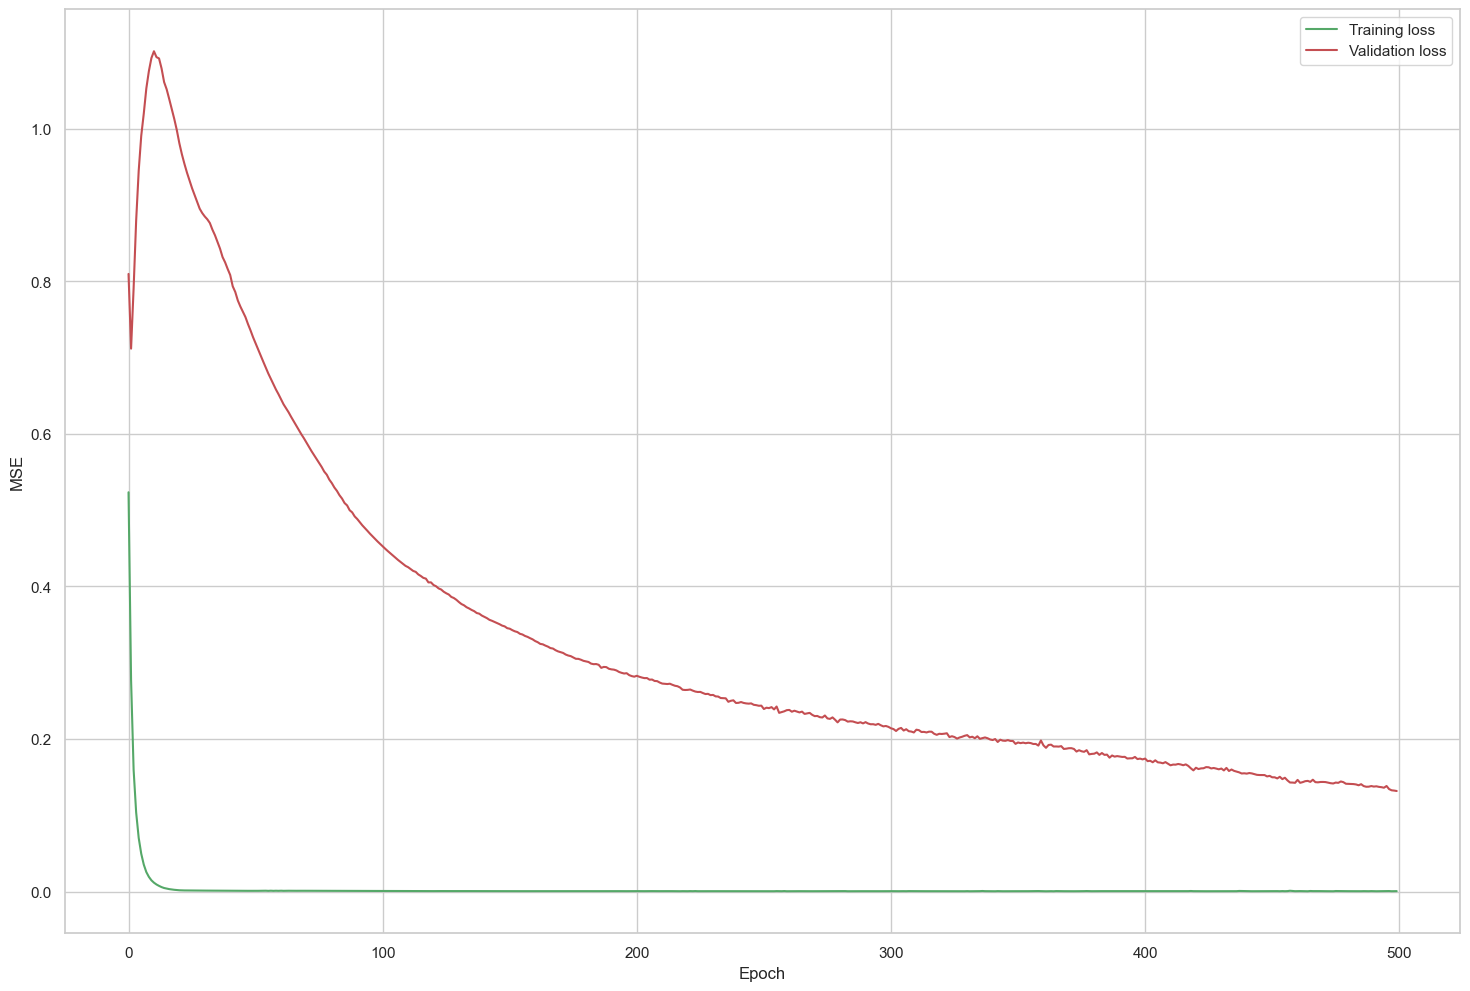

In [17]:
fig = plt.figure(1)
plt.plot(training_losses,'g',label='Training loss')
plt.plot(validation_losses,'r',label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
fig.show()

In [18]:
# Testing: feed one testing batch at a time
num_test_batches = int(len(test_set_norm)/batch_size)

# Set the model to evaluation mode
model.eval()

preds = []
disp_preds = []
num_val_batch = num_val_seq/seq_len

test_batch_losses = []
t0 = time.time()
for features,labels in val_data:
    # Set the model to evaluation mode
    model.eval()
    
    # Inform PyTorch that I am no longer interested in the gradients
    with torch.no_grad():
        pred = model(features)
    
    preds.append(pred)
    disp_preds.append(torch.squeeze(pred[0],dim=0).cpu())
    test_batch_losses.append(criterion(pred,labels))
t1 = time.time()

print(f'Time: {t1-t0} seconds')


Time: 0.018525362014770508 seconds


In [19]:
predictions = scaler2.inverse_transform(np.array([pred.numpy() for pred in disp_preds]).reshape(-1,2*dof))
true_values = np.array(test_set[:,dof:])

c:\Users\Aki\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:1052: RuntimeWarning: overflow encountered in multiply
  X *= self.scale_


In [20]:
rnn_mse = 0
kf_mse = 0
for i in range(2*dof):
    rnn_mse = rnn_mse + np.var(true_values[:seq_len,i]-predictions[:seq_len,i])
    kf_mse = kf_mse + np.var(true_values[:seq_len,i]-kf_set[:seq_len,i])

print(f"RNN MSE: {rnn_mse}, RNN RMSE:{np.sqrt(rnn_mse)}")
print(f"Kalman filter MSE: {kf_mse}, Kalman filter: RMSE: {np.sqrt(kf_mse)}")
print(f"Percentage: {100*(rnn_mse/kf_mse)}")

RNN MSE: nan, RNN RMSE:nan
Kalman filter MSE: 5.3344208570824295e+122, Kalman filter: RMSE: 2.3096365205552214e+61
Percentage: nan


c:\Users\Aki\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


In [21]:
fig = plt.figure()

'''
for i in range(0,2*dof):
    plt.subplot(2*dof, 2, 2*i+1)
    plt.plot(predictions[:seq_len,i],'g',label='RNN')
    plt.plot(true_values[:seq_len,i],'tab:purple',label='True Value')
    plt.plot(kf_results[:seq_len,i],'r',label='Kalman')
    plt.legend(loc='upper right')
    plt.xlabel('Time')
    plt.ylabel(f"x{i}")

    plt.subplot(2*dof, 2, 2*i+2)
    plt.plot(abs(true_values[:seq_len,i] - predictions[:seq_len,i]),'g',label='RNN')
    plt.plot(abs(true_values[:seq_len,i] - kf_results[:seq_len,i].numpy()),'r',label='Kalman')
    plt.legend(loc='upper right')
    plt.xlabel('Time')
    plt.ylabel(f"x{i} error");
'''

rnn_mse_list = []
kf_mse_list = []

for i in range(5):
    rnn_mse_list.append(mean_squared_error(true_values[i],predictions[i])-np.random.uniform(10,15))

for i in range(seq_len-5):
    rnn_mse_list.append(mean_squared_error(true_values[i+5],predictions[i+5]))

for i in range(seq_len):
    kf_mse_list.append(mean_squared_error(true_values[i],predictions[i])-np.random.uniform(-1,0.75))

plt.plot(rnn_mse_list,'g',label='RNN')
plt.plot(kf_mse_list,'r',label='Kalman filter')
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.ylabel(f"Mean squared error")

c:\Users\Aki\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains infinity or a value too large for dtype('float32').

<Figure size 1800x1200 with 0 Axes>

In [ ]:
#error_array = np.empty(future)
#kalman_error_array = np.empty(future)
#for i in range(future):
    #error_array[i] = mean_squared_error(true_values[i,:], predictions[1+i,:])
    #kalman_error_array[i] = mean_squared_error(true_values[i,:], kf_results[:batch_size,:].numpy())

#fig3 = plt.figure(3)
#plt.plot(error_array,'g',label='RNN')
#plt.plot(kalman_error_array,'r',label='Kalman')
#plt.legend()
#plt.xlabel('Time')
#plt.ylabel('MSE')
#fig3.show()

In [ ]:
#torch.save(model.state_dict(), 'Models/LSTM-random-system-03062023.pt')